# Классификация пород кошек и собак по лицу

Используем упрощенный датасет [Oxford-IIIT Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) с вырезанными лицами домашних животных. Для начала загружаем датасет:

In [2]:
!wget http://www.soshnikov.com/permanent/data/petfaces.tar.gz
!tar xfz petfaces.tar.gz
!rm petfaces.tar.gz

--2023-05-07 15:38:26--  http://www.soshnikov.com/permanent/data/petfaces.tar.gz
Resolving www.soshnikov.com (www.soshnikov.com)... 79.137.227.122
Connecting to www.soshnikov.com (www.soshnikov.com)|79.137.227.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24483412 (23M) [application/x-tar]
Saving to: ‘petfaces.tar.gz’

petfaces.tar.gz     100%[===================>]  23.35M   797KB/s    in 30s     

2023-05-07 15:38:57 (789 KB/s) - ‘petfaces.tar.gz’ saved [24483412/24483412]



Для визуализации списка изображений можно использовать такую функцию:

In [3]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


def display_images(l,titles=None,fontsize=12):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
        if titles is not None:
            ax[i].set_title(titles[i],fontsize=fontsize)
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

Посмотрим, сколько всего изображений у нас есть.

In [4]:
import pathlib


data_dir = pathlib.Path('petfaces')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


3211


Проверим картинку из датасета.

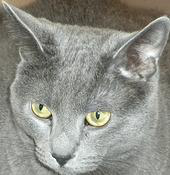

In [8]:
russian_cats = list(data_dir.glob('cat_Russian/*'))
Image.open(str(russian_cats[7]))

# Работа с данными

Поделим датасет на обучающую (80%) и тестовую (20%) выборки: 

In [14]:
batch_size = 32
img_height = 128
img_width = 128

train_data = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=0xDEAD,  # Для воспроизводимости результата
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_data = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=0xDEAD,  # Для воспроизводимости результата
  image_size=(img_height, img_width),
  batch_size=batch_size)



Found 3211 files belonging to 35 classes.
Using 2569 files for training.
Found 3211 files belonging to 35 classes.
Using 642 files for validation.


Посмотрим, какие типы животных у нас есть.

In [9]:
print(train_data.class_names)

['cat_Abyssinian', 'cat_Bengal', 'cat_Birman', 'cat_Bombay', 'cat_British', 'cat_Egyptian', 'cat_Maine', 'cat_Persian', 'cat_Ragdoll', 'cat_Russian', 'cat_Siamese', 'cat_Sphynx', 'dog_american', 'dog_basset', 'dog_beagle', 'dog_boxer', 'dog_chihuahua', 'dog_english', 'dog_german', 'dog_great', 'dog_havanese', 'dog_japanese', 'dog_keeshond', 'dog_leonberger', 'dog_miniature', 'dog_newfoundland', 'dog_pomeranian', 'dog_pug', 'dog_saint', 'dog_samoyed', 'dog_scottish', 'dog_shiba', 'dog_staffordshire', 'dog_wheaten', 'dog_yorkshire']


Заметим, что класс животных начинается с cat или dog. Пронумеруем все классы.

In [15]:
cats_classes = []
dogs_classes = []

for i, class_name in enumerate(train_data.class_names):
    if class_name.startswith('cat'):
        cats_classes.append(i)
    else:
        dogs_classes.append(i)

print('Cats:', cats_classes)
print('Dogs:', dogs_classes)

Cats: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
Dogs: [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]


Закинем датасет в кэш, чтобы быстрее получать изображения оттуда.

In [16]:
class_names = train_data.class_names
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Обучение 

Сначала сделаем аугментацию данных для улучшения классификации. Далее опишем нейросеть.

In [18]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # нормализация
    layers.Conv2D(16, 3, activation='relu'),  # свёртка
    layers.MaxPooling2D(2),  # пулинг
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),  # уменьшаем размерность
    layers.Dropout(0.2),  # избегаем переобучения 
    layers.Dense(num_classes),
    layers.Softmax()
])

Определим подсчёт top-3 accuracy и accuracy. Оптимизатором будет Adam, в качестве функции потерь будем использовать CrossEntropyLoss.

In [19]:
top3_acc = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name='top_3_accuracy')

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', top3_acc])

Посмотрим на строение модели.

In [20]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 128, 128, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                  

Запускаем обучение.

In [21]:
tf.config.list_physical_devices('GPU')

history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50
)

Epoch 1/50
81/81 [==============================] - 15s 27ms/step - loss: 3.3418 - accuracy: 0.0852 - top_3_accuracy: 0.2149 - val_loss: 2.8632 - val_accuracy: 0.2072 - val_top_3_accuracy: 0.4128
Epoch 2/50
81/81 [==============================] - 1s 12ms/step - loss: 2.6938 - accuracy: 0.2581 - top_3_accuracy: 0.4745 - val_loss: 2.3069 - val_accuracy: 0.3536 - val_top_3_accuracy: 0.5919
Epoch 3/50
81/81 [==============================] - 1s 12ms/step - loss: 2.2728 - accuracy: 0.3694 - top_3_accuracy: 0.6010 - val_loss: 2.0004 - val_accuracy: 0.4159 - val_top_3_accuracy: 0.6963
Epoch 4/50
81/81 [==============================] - 1s 12ms/step - loss: 2.0417 - accuracy: 0.4200 - top_3_accuracy: 0.6617 - val_loss: 1.9391 - val_accuracy: 0.4393 - val_top_3_accuracy: 0.7134
Epoch 5/50
81/81 [==============================] - 1s 12ms/step - loss: 1.8456 - accuracy: 0.4733 - top_3_accuracy: 0.7112 - val_loss: 1.6994 - val_accuracy: 0.4844 - val_top_3_accuracy: 0.7695
Epoch 6/50
81/81 [======

После обучения: loss: 0.3244 - accuracy: 0.8926 - top_3_accuracy: 0.9825 - val_loss: 1.6040 - val_accuracy: 0.6604 - val_top_3_accuracy: 0.8832. Нарисуем эти метрики на графиках.

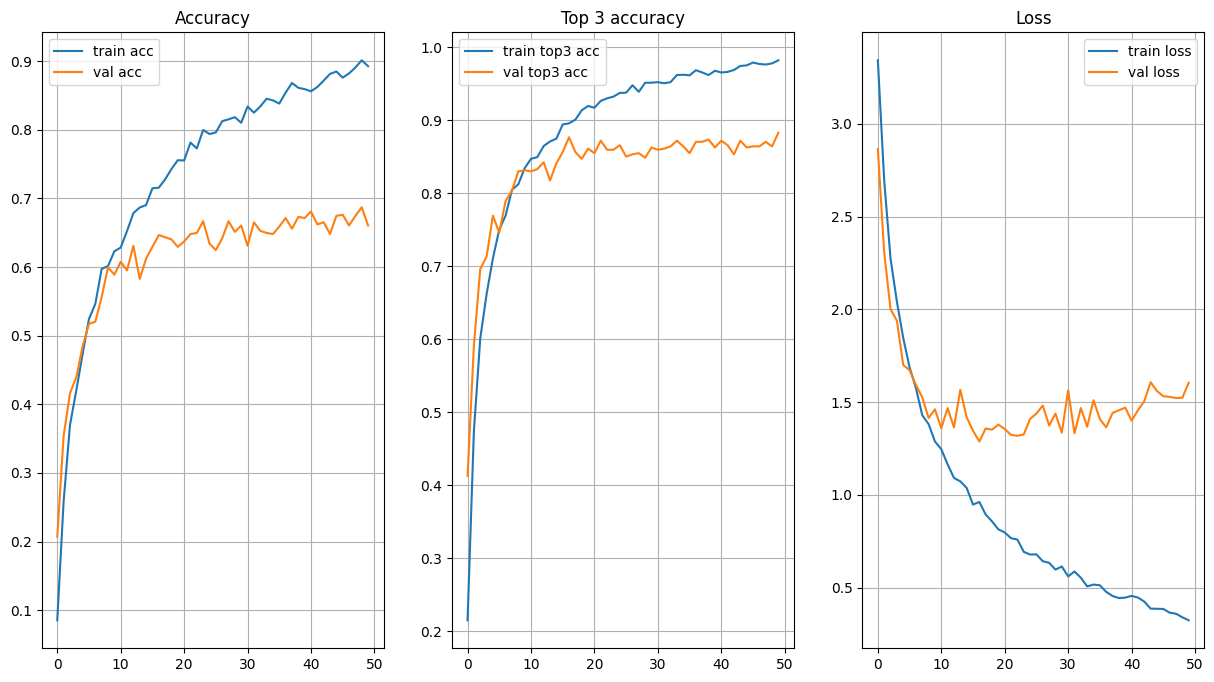

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']

epochs = 50
epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='train acc')
plt.plot(epochs_range, val_acc, label='val acc')
plt.legend()
plt.grid()
plt.title('Accuracy')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, top3_acc, label='train top3 acc')
plt.plot(epochs_range, val_top3_acc, label='val top3 acc')
plt.legend()
plt.grid()
plt.title('Top 3 accuracy')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, loss, label='train loss')
plt.plot(epochs_range, val_loss, label='val loss')
plt.legend()
plt.grid()
plt.title('Loss')

plt.show()

Мы пробовали много разных конфигураций модели: меняли количество и параметры сверточных слоев, добавляли больше линейных слоев, меняли лернинг рейт и количество эпох. По итогу эта модель оказалась наилучшей по метрикам.

Посчитаем точность двоичной классификации "кошки против собак" на тестовом датасете.

In [24]:
correct = 0
total = 0

for x, y in test_data:
  y_pred = np.argmax(model.predict(x), axis=1)
  correct_cats = sum([y_pred[i] in cats_classes and y[i] in cats_classes for i in range(len(y))])
  correct_dogs = sum([y_pred[i] in dogs_classes and y[i] in dogs_classes for i in range(len(y))])
  correct += correct_cats + correct_dogs
  total += len(y)
print(correct / total)

1/1 [==============================] - 0s 70ms/step
0.956386292834891


Точность cats vs dogs - 0.956386292834891.

Построим confusion matrix.

In [25]:
import seaborn as sn
import pandas as pd


def plot_confusion_matrix(model, data):
    y_real = np.array([])
    y_pred = np.array([])

    for x, y in data:
        y_real = np.concatenate((y_real, y), axis=None)
        y_pred = np.concatenate((y_pred, np.argmax(model.predict(x), axis=1)), axis=None)    
    conf_matrix = tf.math.confusion_matrix(y_real, y_pred, num_classes=num_classes)
    
    df_cm = pd.DataFrame(conf_matrix, index = [i for i in class_names], columns = [i for i in class_names])
    plt.figure(figsize = (15, 15))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    plt.show()

1/1 [==============================] - 0s 21ms/step


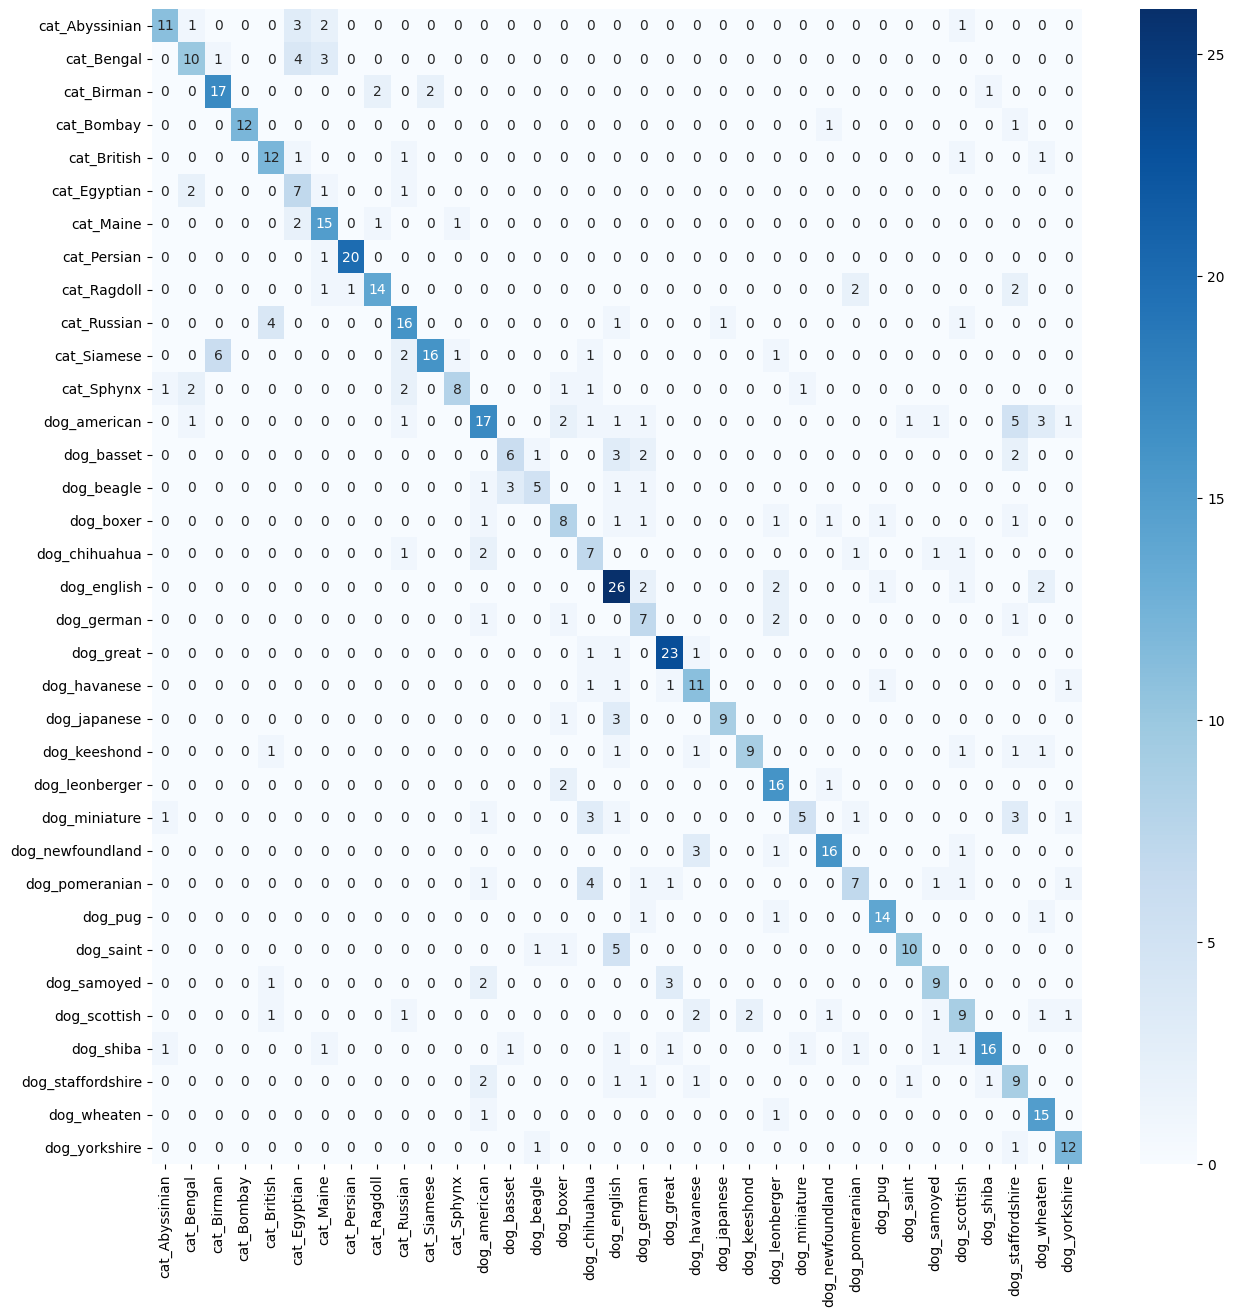

In [26]:
plot_confusion_matrix(model, test_data)